<a href="https://colab.research.google.com/github/masoudbarzegari/Detection-breast-cancer/blob/cancer/mammography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data download

In [25]:
!curl http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz -o all-mias.tar.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  106M  100  106M    0     0  10.0M      0  0:00:10  0:00:10 --:--:-- 11.3M


# ***Mkdir***

In [26]:
!ls
!tar xvzf all-mias.tar.gz
!mkdir all-mias
!mv *.pgm all-mias

all-mias  all-mias.tar.gz  drive  sample_data
Info.txt
Licence.txt
README
mdb001.pgm
mdb002.pgm
mdb003.pgm
mdb004.pgm
mdb005.pgm
mdb006.pgm
mdb007.pgm
mdb008.pgm
mdb009.pgm
mdb010.pgm
mdb011.pgm
mdb012.pgm
mdb013.pgm
mdb014.pgm
mdb015.pgm
mdb016.pgm
mdb017.pgm
mdb018.pgm
mdb019.pgm
mdb020.pgm
mdb021.pgm
mdb022.pgm
mdb023.pgm
mdb024.pgm
mdb025.pgm
mdb026.pgm
mdb027.pgm
mdb028.pgm
mdb029.pgm
mdb030.pgm
mdb031.pgm
mdb032.pgm
mdb033.pgm
mdb034.pgm
mdb035.pgm
mdb036.pgm
mdb037.pgm
mdb038.pgm
mdb039.pgm
mdb040.pgm
mdb041.pgm
mdb042.pgm
mdb043.pgm
mdb044.pgm
mdb045.pgm
mdb046.pgm
mdb047.pgm
mdb048.pgm
mdb049.pgm
mdb050.pgm
mdb051.pgm
mdb052.pgm
mdb053.pgm
mdb054.pgm
mdb055.pgm
mdb056.pgm
mdb057.pgm
mdb058.pgm
mdb059.pgm
mdb060.pgm
mdb061.pgm
mdb062.pgm
mdb063.pgm
mdb064.pgm
mdb065.pgm
mdb066.pgm
mdb067.pgm
mdb068.pgm
mdb069.pgm
mdb070.pgm
mdb071.pgm
mdb072.pgm
mdb073.pgm
mdb074.pgm
mdb075.pgm
mdb076.pgm
mdb077.pgm
mdb078.pgm
mdb079.pgm
mdb080.pgm
mdb081.pgm
mdb082.pgm
mdb083.pgm
mdb084.pgm
md

In [2]:
import glob
import os
from PIL import Image

# Save weight model

In [3]:
no_angles = 360
url ='/content/drive/My Drive/all-mias/'
def save_dictionary(path,data):
    print('saving catalog...')
    #open('u.item', encoding="utf-8")
    import json
    with open(path,'w') as outfile:
      json.dump(str(data), fp=outfile)
      # save to file:
    print(' catalog saved')

# **Read iamge**

In [28]:
def read_image():
    import cv2
    info = {}
    for i in range(322):
        if i<9:
            image_name='mdb00'+str(i+1)
        elif i<99:
            image_name='mdb0'+str(i+1)
        else:
            image_name = 'mdb' +str(i+1)
        # print(image_name)
        image_address= url+image_name+'.pgm'
        print(image_address)
        img = cv2.imread(image_address, 0)
        # print(i)
        img = cv2.resize(img, (64,64))   #resize image
        rows, cols = img.shape

        info[image_name]={}
        for angle in range(no_angles):
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)    #Rotate 0 degree
            img_rotated = cv2.warpAffine(img, M, (cols, rows))
            info[image_name][angle]=img_rotated
    return (info)


# Type model

In [29]:
def read_lable():
    filename = url+'Info.txt'
    text_all = open(filename).read()
    lines=text_all.split('\n')
    info={}
    for line in lines:
      words=line.split(' ')
      if len(words)>3:
          if (words[3] == 'B'):
              info[words[0]] = {}
              for angle in range(no_angles):
                info[words[0]][angle] = 0
          if (words[3] == 'M'):
            info[words[0]] = {}
            for  angle in range(no_angles):
              info[words[0]][angle] = 1
          if (words[2] == 'NORM'):
           info[words[0]] = {}
           for angle in range(no_angles):
            info[words[0]][angle] = 2

    return (info)

# Data Agmination

In [30]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# Split data

In [31]:
def training():
    from sklearn.model_selection import train_test_split
    import numpy as np
    lable_info=read_lable()
    image_info=read_image()
    ids=lable_info.keys()
    del lable_info['Truth-Data:']
    X=[]
    Y=[]
    for id in ids:
        for angle in range(no_angles):
            X.append(image_info[id][angle])
            Y.append(lable_info[id][angle])
    X=np.array(X)
    Y=np.array(Y)

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
    x_train,val_train, y_train, val_test  = train_test_split(x_train, y_train,  test_size=0.10, random_state=42)
    (a,b,c)=x_train.shape
    x_train = np.reshape(x_train, (a, b, c, 1))
    (a, b, c)=x_test.shape
    x_test = np.reshape(x_test, (a, b, c, 1))
    (a, b, c)=val_train.shape
    val_train = np.reshape(val_train, (a, b, c, 1))
    datagen.fit(x_train)
    datagen.flow(x_train)
    cancer_prediction_cnn(x_train, y_train, x_test, y_test, val_train , val_test)
    len(x_test)

#Train model

In [32]:
import matplotlib.pyplot as plt


/content/drive/My Drive/all-mias/mdb001.pgm
/content/drive/My Drive/all-mias/mdb002.pgm
/content/drive/My Drive/all-mias/mdb003.pgm
/content/drive/My Drive/all-mias/mdb004.pgm
/content/drive/My Drive/all-mias/mdb005.pgm
/content/drive/My Drive/all-mias/mdb006.pgm
/content/drive/My Drive/all-mias/mdb007.pgm
/content/drive/My Drive/all-mias/mdb008.pgm
/content/drive/My Drive/all-mias/mdb009.pgm
/content/drive/My Drive/all-mias/mdb010.pgm
/content/drive/My Drive/all-mias/mdb011.pgm
/content/drive/My Drive/all-mias/mdb012.pgm
/content/drive/My Drive/all-mias/mdb013.pgm
/content/drive/My Drive/all-mias/mdb014.pgm
/content/drive/My Drive/all-mias/mdb015.pgm
/content/drive/My Drive/all-mias/mdb016.pgm
/content/drive/My Drive/all-mias/mdb017.pgm
/content/drive/My Drive/all-mias/mdb018.pgm
/content/drive/My Drive/all-mias/mdb019.pgm
/content/drive/My Drive/all-mias/mdb020.pgm
/content/drive/My Drive/all-mias/mdb021.pgm
/content/drive/My Drive/all-mias/mdb022.pgm
/content/drive/My Drive/all-mias

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


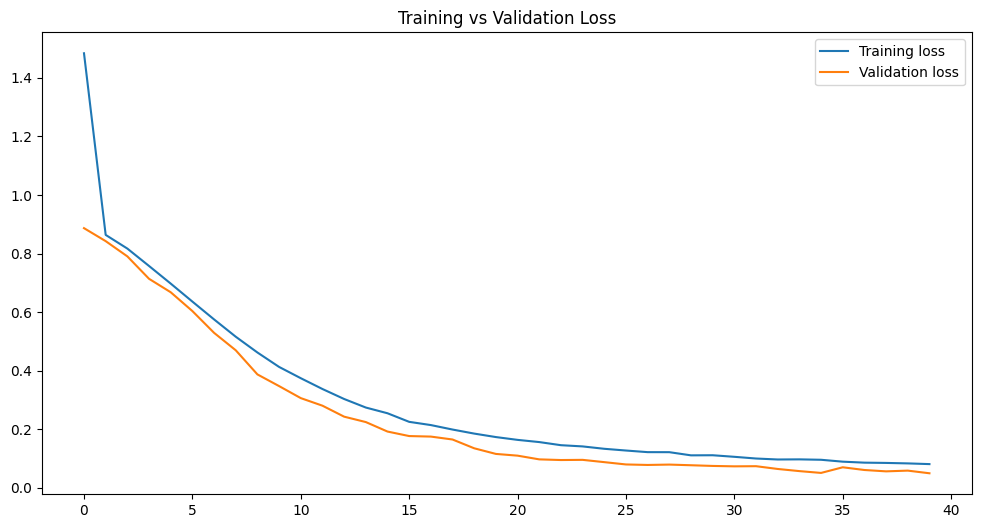

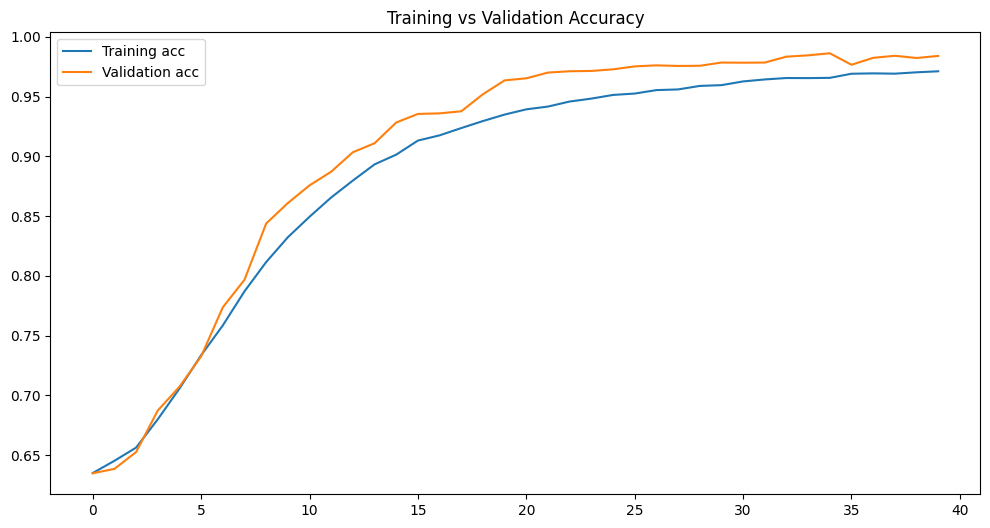

In [33]:

def cancer_prediction_cnn(x_train,y_train,x_test,y_test, val_train, val_test):
    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
    from keras import optimizers
    from keras import losses
    rows, cols,color = x_train[0].shape
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(rows, cols, 1) , padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3) , padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train,y_train, epochs=40, batch_size=128 ,verbose=1,validation_data=(val_train, val_test))
    loss_value , metrics = model.evaluate(x_test, y_test)
    print('Test_loss_value = ' +str(loss_value))
    print('test_accuracy = ' + str(metrics))
    model.save('breast_cance_model.h5')
    #plot loss functin
    save_dictionary('history1.dat', history.history)
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label="Training loss")
    plt.plot(history.history['val_loss'], label="Validation loss")
    plt.legend()
    plt.title("Training vs Validation Loss")
    plt.show()
    #plot loss functin
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label="Training acc")
    plt.plot(history.history['val_accuracy'], label="Validation acc")
    plt.legend()
    plt.title("Training vs Validation Accuracy")
    plt.show()
training()

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
!cp "/content/all-mias/mdb130.pgm" "/content/drive/MyDrive/all-mias/mdb130.pgm"